## Settings

In [ ]:
import random
import time
import os
import datetime
import itertools
import math
import sys
from random import randint
import shutil
import gc

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
if IN_COLAB:
  COLAB_BASE_DIR = "/content/gdrive/MyDrive/Universidad/VIU/TFM/notebooks/"
  from google.colab import drive
  drive.mount('/content/gdrive/')
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'ConvLSTM'))
  sys.path.append(os.path.join(COLAB_BASE_DIR, 'common'))

Mounted at /content/gdrive/


In [ ]:
drive_comp_clouds_path = os.path.join(COLAB_BASE_DIR, 'common/processed_lstmcomparison.hdf5')
comp_clouds_path = "/data/processed_lstmcomparison.hdf5"
if IN_COLAB:
  if not os.path.exists("/data/mask_black_skygptdata.png"):
    %mkdir -p /data
    shutil.copyfile(drive_comp_clouds_path, comp_clouds_path)
    !gdown 1OEqxhm4NrK1NDsQaBxuG22YY3K92SduH
    %mv /content/*.png /data/

Downloading...
From: https://drive.google.com/uc?id=1OEqxhm4NrK1NDsQaBxuG22YY3K92SduH
To: /content/mask_black_skygptdata.png
100% 5.89k/5.89k [00:00<00:00, 25.4MB/s]


In [ ]:
%%capture
%pip install torch torchvision h5py xarray matplotlib netcdf4 torchmetrics

In [ ]:
import torch
import torchvision
import torchmetrics
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import h5py
import PIL.Image
from IPython.core import display as idisplay
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr

from ConvLSTMmodels import SegmentedConvLSTMNet
if not IN_COLAB:
  sys.path.append('../common')
import common

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data process

In [ ]:
cwd = os.getcwd()
model_name_seg = "MaskedConvLSTM"
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data')
mask_path = os.path.join(data_folder,'mask_black_skygptdata.png')
data_path = comp_clouds_path
output_path = os.path.join(cwd, "save", f"{model_name_seg}.torch")
if IN_COLAB:
  output_path = os.path.join(COLAB_BASE_DIR, "ConvLSTM", f"{model_name_seg}.torch")

In [ ]:
with h5py.File(data_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)

dss = {}
for gname in group_names:
    try:
        dss[gname] = xr.open_dataset(data_path, group=gname)
    except Exception:
        dss[gname] = xr.open_dataset(data_path, group=gname, engine="h5netcdf", phony_dims="sort")

['test']


In [ ]:
mask_png = np.array(PIL.Image.open(mask_path).resize((64, 64)).getdata())
# Mask for size 64
print(mask_png.shape)
mask_to_black = (mask_png[:,3] > 127)
not_mask_to_black = (mask_png[:,3] <= 127)
print(mask_to_black.sum()) # alpha = 1 = black visible
print(not_mask_to_black.sum())
print(not_mask_to_black.sum()+mask_to_black.sum())
mask_to_black = mask_to_black.reshape((64, 64))
empty_mask = np.ones((64, 64, 3))
mask_to_black = np.where(np.expand_dims(mask_to_black, 2), empty_mask, empty_mask*0)

(4096, 4)
1418
2678
4096


In [ ]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.unpackbits(x, axis=1)),
    torch.from_numpy,
    transforms.Lambda(lambda x: torch.permute(x, (2, 0, 1)).float()),
])
bs = 8
btest_dataset_mask_gtruth = common.VideoDataset(dss['test']['masks_log'], dss['test']['masks_targ'], transform=transform, stack_videos=False, device=device)
btest_dataset_mask_preds = common.VideoDataset(dss['test']['masks_pred_seg'], dss['test']['masks_pred_noseg'], transform=transform, stack_videos=False, device=device)
btest_loader_mask_gtruth = DataLoader(btest_dataset_mask_gtruth, batch_size=bs, shuffle=False)
btest_loader_mask_preds = DataLoader(btest_dataset_mask_preds, batch_size=bs, shuffle=False)


print(f"Number of videos: {len(btest_dataset_mask_gtruth.videos)}.")
print(f"Number of video batches: {len(btest_loader_mask_gtruth)}")
print(f"Size of video batches: {bs}.")

Number of videos: 4467.
Number of video batches: 559
Size of video batches: 8.


## Load model

In [ ]:
def load_segconvlstm(path: str, device):
  N_VALUES_CLOUD_MASK = 5
  hidden_dims = [128, 128, 64]
  kernel_size = (3, 3)
  n_layers = 3
  clstm = SegmentedConvLSTMNet(hidden_dims, kernel_size, n_layers, device, n_channels=N_VALUES_CLOUD_MASK, batch_normalization=True)
  clstm.load_state_dict(torch.load(path, map_location='cpu'))
  return clstm

In [ ]:
clstm = load_segconvlstm(output_path, device)

<ipython-input-17-32ea2e3b17df>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  clstm.load_state_dict(torch.load(path, map_location='cpu'))


In [ ]:
cmap = mcolors.ListedColormap(['black', 'cyan', 'yellow', 'white', 'blue'], 'CloudSegmenter')
def show_mask(img):
    labels_again = torch.argmax(img, dim=1).cpu()
    f = plt.figure(figsize=(9, 9), layout='tight')
    ncols = len(img)//4 if len(img) % 4 == 0 else len(img)//4 + 1
    axarr = f.subplots(4,4)
    for i in range(16):
      axarr[i//4][i%4].set_axis_off()
    for i in range(len(img)):
        axarr[i//4][i%4].imshow(labels_again[i], cmap=cmap, vmin=0, vmax=5)
    plt.show()

## Evaluate

In [ ]:
torch.cuda.empty_cache()
loss_function = nn.MSELoss()
_jaca = torchmetrics.JaccardIndex(task="multiclass", num_classes=5).to(device)
def jac(x, y):
  if len(x.shape) == 5:
    x = x.flatten(0, 1)
    y = y.flatten(0, 1)
  return _jaca(torch.argmax(x, axis=1), torch.argmax(y, axis=1))
_dice = torchmetrics.Dice().to(device)
dice = lambda x, y: _dice(torch.argmax(x, axis=len(x.shape)-3), torch.argmax(y, axis=len(y.shape)-3))
_cce = nn.CrossEntropyLoss()
def cce(x, y):
  if len(x.shape) == 5:
    x = x.permute(0, 2, 1, 3, 4)
    y = y.permute(0, 2, 1, 3, 4)
  return _cce(x, y)
loss_functions = [cce, jac, dice]

losses_tsteps = [0 for _ in range(15)]
loss = 0
losses_tstepss = [[0 for _ in range(15)] for _ in range(len(loss_functions))]
losses = [0 for _ in range(len(loss_functions))]

test_loader = btest_loader_mask_gtruth

with torch.no_grad():
  clstm.eval()
  for idx, ((videos, targets), (outputs, _)) in enumerate(zip(test_loader, btest_loader_mask_preds)):
    #outputs = clstm(videos, targets.size(1))
    #if idx % 50 == 0:
    #  show_mask(outputs[0].cpu())
    #  show_mask(targets[0].cpu())
    for i in range(15):
      lossp = loss_function(outputs[:,i,:,:,:], targets[:,i,:,:,:])
      losses_tsteps[i] += lossp.item()
      for l, lossf in enumerate(loss_functions):
        lossp = lossf(outputs[:,i,:,:,:], targets[:,i,:,:,:])
        losses_tstepss[l][i] += lossp.item()
    if idx %10 == 0:
      print(f"Batch {idx}/{len(test_loader)}")
    lossp = loss_function(outputs, targets)
    loss += lossp.item()
    for l, lossf in enumerate(loss_functions):
      lossp = lossf(outputs, targets)
      losses[l] += lossp.item()
    lossp = None
    outputs = None

Batch 0/559
Batch 10/559
Batch 20/559
Batch 30/559
Batch 40/559
Batch 50/559
Batch 60/559
Batch 70/559
Batch 80/559
Batch 90/559
Batch 100/559
Batch 110/559
Batch 120/559
Batch 130/559
Batch 140/559
Batch 150/559
Batch 160/559
Batch 170/559
Batch 180/559
Batch 190/559
Batch 200/559
Batch 210/559
Batch 220/559
Batch 230/559
Batch 240/559
Batch 250/559
Batch 260/559
Batch 270/559
Batch 280/559
Batch 290/559
Batch 300/559
Batch 310/559
Batch 320/559
Batch 330/559
Batch 340/559
Batch 350/559
Batch 360/559
Batch 370/559
Batch 380/559
Batch 390/559
Batch 400/559
Batch 410/559
Batch 420/559
Batch 430/559
Batch 440/559
Batch 450/559
Batch 460/559
Batch 470/559
Batch 480/559
Batch 490/559
Batch 500/559
Batch 510/559
Batch 520/559
Batch 530/559
Batch 540/559
Batch 550/559


In [ ]:
print(loss)
print(losses_tsteps)
for l, lossf in enumerate(loss_functions):
  print(losses[l])
  print(losses_tstepss[l])

16.1699946851586
[7.454874813905917, 9.755070160143077, 11.464205092954217, 12.781872794352239, 13.967623150354484, 15.068790939025348, 16.037736279773526, 16.92899603320984, 17.766854160116054, 18.499906739860307, 19.21807487384649, 19.92029252933571, 20.582186217652634, 21.228328757279087, 21.875106132007204]
546.2263653874397
[524.4385452270508, 530.1890345215797, 534.4618710875511, 537.7560414671898, 540.7204177379608, 543.4733366370201, 545.8956988453865, 548.1238488554955, 550.218493103981, 552.0511259436607, 553.84654545784, 555.6020920276642, 557.2568250894547, 558.8721803426743, 560.489122569561]
335.46636936068535
[413.6933382451534, 391.4746353328228, 379.5398126542568, 372.3919829726219, 363.9442480504513, 359.2501694858074, 356.17979595065117, 352.7175269126892, 349.6954964995384, 345.01805794239044, 343.47522139549255, 341.3780339360237, 338.9311301112175, 336.1157431602478, 335.12173894047737]
518.5750150084496
[540.3628132939339, 534.6123250126839, 530.3394877314568, 52

In [ ]:
losses = [0 for _ in range(3)]
losses_tstepss = [None for _ in range(3)]
losses_names = ['Cross Entropy', 'Jaccard Index', 'Dice Coefficient']
loss = 16.1699946851586
losses_tsteps = [7.454874813905917, 9.755070160143077, 11.464205092954217, 12.781872794352239, 13.967623150354484, 15.068790939025348, 16.037736279773526, 16.92899603320984, 17.766854160116054, 18.499906739860307, 19.21807487384649, 19.92029252933571, 20.582186217652634, 21.228328757279087, 21.875106132007204]
losses[0] = 546.2263653874397
losses_tstepss[0] = [524.4385452270508, 530.1890345215797, 534.4618710875511, 537.7560414671898, 540.7204177379608, 543.4733366370201, 545.8956988453865, 548.1238488554955, 550.218493103981, 552.0511259436607, 553.84654545784, 555.6020920276642, 557.2568250894547, 558.8721803426743, 560.489122569561]
losses[1] = 335.46636936068535
losses_tstepss[1] = [413.6933382451534, 391.4746353328228, 379.5398126542568, 372.3919829726219, 363.9442480504513, 359.2501694858074, 356.17979595065117, 352.7175269126892, 349.6954964995384, 345.01805794239044, 343.47522139549255, 341.3780339360237, 338.9311301112175, 336.1157431602478, 335.12173894047737]
losses[2] = 518.5750150084496
losses_tstepss[2] = [540.3628132939339, 534.6123250126839, 530.3394877314568, 527.0453186035156, 524.0809428095818, 521.3280232548714, 518.9056599736214, 516.6775105595589, 514.5828654170036, 512.7502339482307, 510.95481365919113, 509.199269592762, 507.54453533887863, 505.92917889356613, 504.31223553419113]

In [ ]:
#loss = 3262424.7819519043
#losses_tsteps = [63981.17190861702, 100664.27593231201, 130647.462079525, 156336.8825044632, 178649.03850269318, 198654.0722875595, 216817.39347553253, 233183.7131357193, 247966.19857692719, 261632.34273910522, 273825.75592136383, 284908.21430397034, 295297.4710216522, 305212.1937980652, 314648.55619621277]

#loss = 41349131.70605469
#losses_tsteps = [1141004.8888397217, 1636664.6726989746, 1872717.1052246094, 2129289.774017334, 2344540.0419921875, 2537204.9959106445, 2732632.3549804688, 2892889.1681518555, 3055322.6393432617, 3189344.4845581055, 3320480.2219848633, 3463710.5232543945, 3564810.4611206055, 3681726.7576904297, 3786793.7329101562]
#loss2 = 4540.253136634827
#losses_tsteps2 = [543.1005716323853, 558.2031109333038, 557.9578538537025, 562.1501204967499, 564.0788341164589, 566.8301084041595, 570.0945748090744, 572.252399623394, 575.2008005976677, 576.2743647694588, 578.4406522512436, 580.9230923652649, 581.8462926149368, 583.8577219843864, 585.426403939724]
#loss = 39597818.0
#losses_tsteps = [1216080.0, 1590234.0, 1868882.0, 2083492.0, 2278132.0, 2458604.0, 2618436.0, 2764330.0, 2901718.0, 3021768.0, 3139986.0, 3254614.0, 3361952.0, 3466976.0, 3572614.0]
#loss2 = 743282718.5625
#losses_tsteps2 = [17163607.9453125, 17350684.978515625, 17490008.955078125, 17597313.994140625, 17694634.01171875, 17784869.990234375, 17864785.955078125, 17937732.974609375, 18006426.9453125, 18066451.990234375, 18125560.96484375, 18182875.046875, 18236544.0078125, 18289055.96875, 18341874.931640625]


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
"""n_vidba = 559
n_vidba_mse = 559*8
losses_tsteps = np.array(losses_tsteps)/n_vidba_mse
loss = loss/(15*n_vidba_mse)
losses_tsteps2 = np.array(losses_tsteps2)/n_vidba
loss2 = loss2/(15*n_vidba)
print(loss)
print(losses_tsteps)
print(np.mean(losses_tsteps))
print(loss2)
print(losses_tsteps2)
print(np.mean(losses_tsteps2))"""

'n_vidba = 559\nn_vidba_mse = 559*8\nlosses_tsteps = np.array(losses_tsteps)/n_vidba_mse\nloss = loss/(15*n_vidba_mse)\nlosses_tsteps2 = np.array(losses_tsteps2)/n_vidba\nloss2 = loss2/(15*n_vidba)\nprint(loss)\nprint(losses_tsteps)\nprint(np.mean(losses_tsteps))\nprint(loss2)\nprint(losses_tsteps2)\nprint(np.mean(losses_tsteps2))'

In [ ]:
n_vidba = 559
losses_tstepss = np.array(losses_tstepss)/n_vidba
losses = np.array(losses)/n_vidba

In [ ]:
original_losses = np.array([26.4, 36.3, 44, 50, 55.8, 60, 64.1, 67])/(64*64*3)

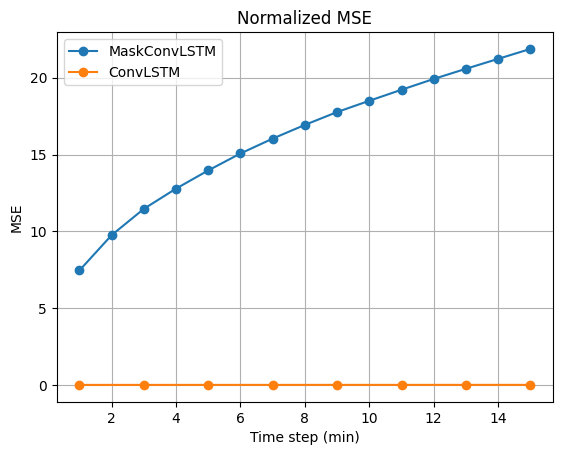

In [ ]:
plt.plot(range(1, 16), losses_tsteps, '-o', label='MaskConvLSTM')
plt.plot(range(1, 16, 2), original_losses, '-o', label='ConvLSTM')
plt.xlabel('Time step (min)')
plt.ylabel('MSE')
plt.title('Normalized MSE')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.plot(range(1, 16), losses_tsteps2, '-o')
plt.xlabel('Time step (min)')
plt.ylabel('Cross-Entropy')
plt.grid()
plt.show()

NameError: name 'losses_tsteps2' is not defined

In [ ]:
print(losses_tstepss)
print(losses)
print(losses_tstepss.mean(axis=1))

[[0.93817271 0.94845981 0.95610353 0.9619965  0.9672995  0.97222422
  0.9765576  0.98054356 0.98429069 0.9875691  0.99078094 0.99392145
  0.99688162 0.99977134 1.0026639 ]
 [0.74005964 0.70031241 0.6789621  0.66617528 0.65106306 0.64266578
  0.63717316 0.63097948 0.62557334 0.61720583 0.61444583 0.61069416
  0.60631687 0.6012804  0.59950222]
 [0.96665977 0.95637267 0.94872896 0.94283599 0.93753299 0.93260827
  0.92827488 0.92428893 0.9205418  0.91726339 0.91405155 0.91091104
  0.90795087 0.90506114 0.90216858]]
[0.97714913 0.60011873 0.92768339]
[0.9771491  0.64149397 0.92768339]


In [ ]:
for lste, name in zip(losses_tstepss, losses_names):
  plt.plot(range(1, 16), lste, '-o')
  plt.xlabel('Time step (min)')
  plt.ylabel(name)
  plt.grid()
  plt.show()